In [3]:
#conectando com o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importando as bibliotecas do TensorFlow e Keras


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12968715351520566095
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11344216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16280590612484422603
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


Escolhendo o dataset

Verificando se a importação foi bem sucedida


In [4]:
import pathlib
#dataset_url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset/download"
#data_dir = tf.keras.utils.get_file('covid_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path('C:/Users/Helal/Documents/Untitled Folder/Floresta')
data_dir = pathlib.Path('/content/drive/MyDrive/datasetFlorestaV3/treinamento')
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count) #verificar se o número de imagens importadas coincide com o número de imagens do dataset de treinamento


4599


In [8]:
veado = list(data_dir.glob('veado/*'))
PIL.Image.open(str(veado[1000])) 
#Exemplo de imagem do dataset de treinamento - VEADO

Output hidden; open in https://colab.research.google.com to view.

In [9]:
porco = list(data_dir.glob('porco/*'))
PIL.Image.open(str(porco[1000])) 
#Exemplo de imagem do dataset de treinamento - PORCO

Output hidden; open in https://colab.research.google.com to view.

In [10]:
tatu = list(data_dir.glob('tatu/*'))
PIL.Image.open(str(tatu[1000])) 
#Exemplo de imagem do dataset de treinamento - TATU

Output hidden; open in https://colab.research.google.com to view.

Criando os datasets de treino e validação

In [5]:
batch_size = 32
img_height = 400
img_width = 400

In [12]:
#definindo que 80% das imagens do dataset será usada para treinamento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4599 files belonging to 3 classes.
Using 3680 files for training.


In [13]:
#definindo que 20% das imagens do dataset será usada par validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4599 files belonging to 3 classes.
Using 919 files for validation.


In [14]:
#verificando se foram criadas as classes com o nomes das pastas onde estão o dataset
class_names = train_ds.class_names
print(class_names)

['porco', 'tatu', 'veado']


Visualizando o dataset de treinamento

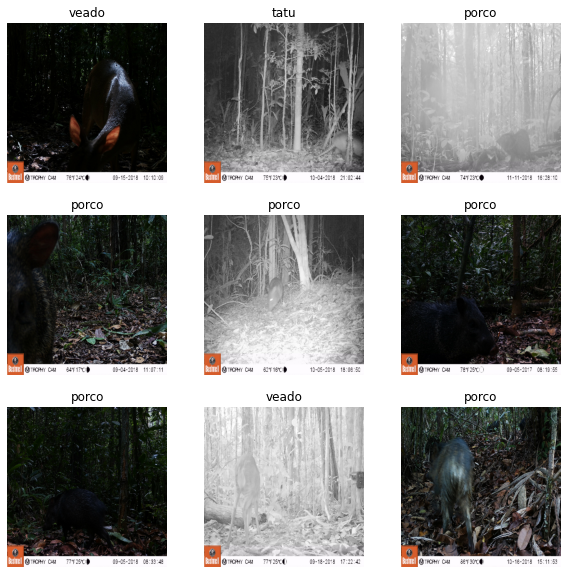

In [15]:
#apenas para debug
#verificar se até o momento tudo que foi feito com o dataset está correto
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 400, 400, 3)
(32,)


Configurando o dataset para performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalizando os dados

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 
#Esse processo demorou 21 minutos

0.0 1.0


Criando o modelo

In [7]:
num_classes = 3 #Cutia, Porco, Tatu

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 400, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0

Data Augmentation

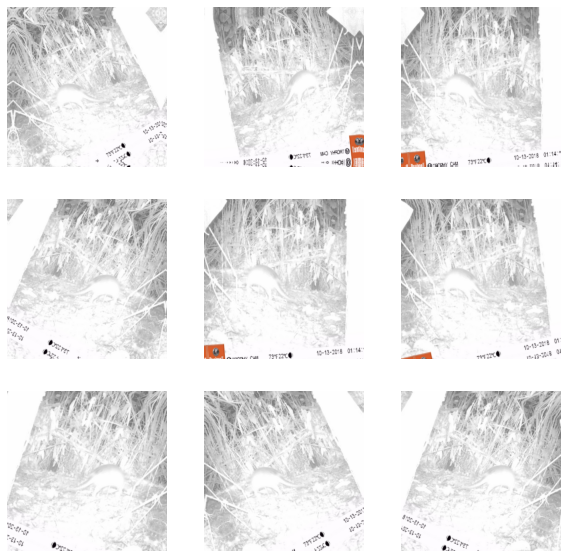

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


Compilando o modelo

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Treinando o modelo

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
115/115 [==============================] - 265s 2s/step - loss: 1.1997 - accuracy: 0.7234 - val_loss: 0.3471 - val_accuracy: 0.8814
Epoch 2/10
115/115 [==============================] - 10s 89ms/step - loss: 0.2583 - accuracy: 0.8962 - val_loss: 0.1833 - val_accuracy: 0.9195
Epoch 3/10
115/115 [==============================] - 10s 89ms/step - loss: 0.1016 - accuracy: 0.9696 - val_loss: 0.0741 - val_accuracy: 0.9793
Epoch 4/10
115/115 [==============================] - 10s 90ms/step - loss: 0.0984 - accuracy: 0.9682 - val_loss: 0.1477 - val_accuracy: 0.9271
Epoch 5/10
115/115 [==============================] - 11s 91ms/step - loss: 0.0491 - accuracy: 0.9853 - val_loss: 0.0431 - val_accuracy: 0.9946
Epoch 6/10
115/115 [==============================] - 10s 91ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0368 - val_accuracy: 0.9967
Epoch 7/10
115/115 [==============================] - 10s 91ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0367 - val_accuracy: 

Salvando a rede e seus pesos

In [23]:
model.save("meuModeloUFESV3.h5")

Resultado do Treinamento

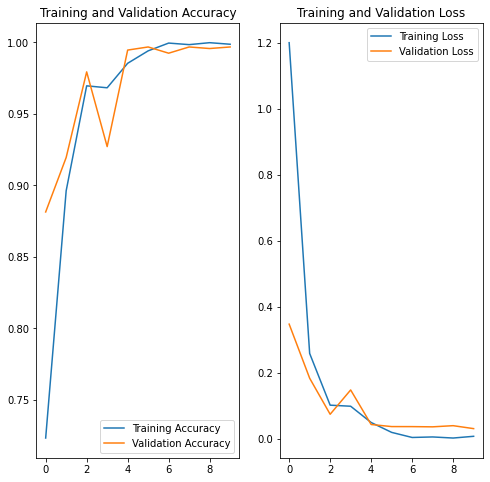

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



```
# This is formatted as code
```

Testando com a base de Veados conhecida


Testando com a base de Tatus conhecida

In [31]:
import matplotlib.image as mpimg
tatus = pathlib.Path('/content/drive/MyDrive/datasetFlorestaV3/teste/tatu')
images = list(tatus.glob('*.JPG'))

v = 0
p = 0
t = 0

for i in images:
    img = mpimg.imread(i)
    img = keras.preprocessing.image.load_img(
        i, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == "porco":
        p = p + 1
    elif class_names[np.argmax(score)] == "tatu":
        t = t + 1
    else:
        v = v + 1
  
print('Veado: {}'.format(v)) 
print('Porco: {}'.format(p)) 
print('Tatu: {}'.format(t)) 


Veado: 0
Porco: 7
Tatu: 249


Testando com a base de Porcos conhecida

In [32]:
porcos = pathlib.Path('/content/drive/MyDrive/datasetFlorestaV3/teste/porco')
images = list(porcos.glob('*.JPG'))

v = 0
p = 0
t = 0

for i in images:
    img = mpimg.imread(i)
    img = keras.preprocessing.image.load_img(
        i, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == "porco":
        p = p + 1
    elif class_names[np.argmax(score)] == "tatu":
        t = t + 1
    else:
        c = v + 1


print('Porco: {}'.format(p)) 
print('Tatu: {}'.format(t)) 
print('Veado: {}'.format(v)) 

Porco: 184
Tatu: 0
Veado: 0


Testando com a base de Porcos conhecida

In [38]:
veados = pathlib.Path('/content/drive/MyDrive/datasetFlorestaV3/teste/veado')
images = list(veados.glob('*.JPG'))


v = 0
p = 0
t = 0

for i in images:
    img = mpimg.imread(i)
    img = keras.preprocessing.image.load_img(
        i, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == "porco":
        p = p + 1
    elif class_names[np.argmax(score)] == "tatu":
        t = t + 1
    else:
        v = v + 1 

print('Porco: {}'.format(p)) 
print('Tatu: {}'.format(t)) 
print('Veado: {}'.format(v)) 

Porco: 14
Tatu: 14
Veado: 126


Classificar imagem da internet

In [ ]:
photo_url = "https://s.afnoticias.com.br/cache/2021/6589b0fbb348d420cbd9c98b0645c11b.jpg"
photo_path = tf.keras.utils.get_file('imagem21', origin=photo_url)

img = keras.preprocessing.image.load_img(
    photo_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)